In [1]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=.50
import jax
import jax.random as jrandom
import jax.scipy.stats as jst
import jax.numpy as jnp
import time
import matplotlib.pyplot as plt
import numpy as np

env: XLA_PYTHON_CLIENT_MEM_FRACTION=.50


In [2]:
class GibbsGMM():
    
    def __init__(self, x, x_out, K, sigma, alpha, eta, PRNGKey):
        
        self.x = jnp.asarray(x) # shape (n, d)
        self.x_out = jnp.asarray(x_out) # shape (n_out, d)
        self.K = K # number of components
        self.sigma = sigma # hyperparameter to the Gaussians (sd)
        self.alpha = alpha # hyperparameter to a K-Dirchlet
        self.eta = eta # hyperparameter to the prior over the components (sd)
        self.key = PRNGKey # initial random PRNGKey
        
        self.d = x.shape[1] # d = 3 or 3 * 32 * 32, depends on how we treat the data        
        self.n = x.shape[0] # number of datapoints
        self.n_out = x_out.shape[0] # number of out-of-sample datapoints
        self.lst_K = jnp.arange(0, self.K, 1)#[:, None] # shape (K, 1) list of components for jax.vmap
        self.lst_n = jnp.arange(0, self.n, 1)#[:, None] # shape (n, 1) list of datapoints for jax.vmap
        self.lst_n_out = jnp.arange(0, self.n_out, 1)#[:,None]# shape (n_out, 1) list of datapoints for jax.vmap
        

        # histories
        self.theta_hist = []
        self.z_hist = []
        self.beta_hist = []
        self.logjoint_hist = []
        self.logptheta_hist = []
        self.logpbeta_hist = []
        self.logpz_hist = []
        self.logpx_hist = []
        self.xbar_hist = []
        self.muhat_hist = []
        self.etahat2_hist = []
        self.N_hist = []
        
        
        # initialize theta, beta, z, and also
        # initialize things for posteriors xbar, n1,n2,...,nK, muhat, etahat^2
        self.theta = jnp.ones((1,self.K))/self.K # shape (1, K)
        self.beta = self.x[jrandom.choice(self.key, self.lst_n, [3,], replace=False)]
        self.Theta = jnp.repeat(self.theta, self.n, axis=0) # shape (n, K)
        self.z_cat = jrandom.categorical(self.key, jnp.log(self.Theta), axis=1)[:, None]# shape (n, 1), categorical integer
        self.z = jax.vmap(self.cat_to_indvec)(self.z_cat) # shape (n, K), indicator vector
        self.N = jnp.sum(self.z, axis=0) # the vector of (n_1, n_2, .., n_K)
        self.xbar = None
        self.muhat = None
        self.etahat2 = None
        self.theta_hist.append(self.theta)
        self.z_hist.append(self.z_cat)
        self.beta_hist.append(self.beta)
        
    # functions to calculate log joint        
        
    def update_key(self):
        # update random key
        _, self.key =  jrandom.split(self.key)
        
    def cat_to_indvec(self, cat):
        
        indvec = jnp.zeros(self.K)
        indvec = indvec.at[cat].set(1)
        
        return indvec
    
    
    def indvec_to_cat(self, vec):
        
        cat = jnp.where(vec==1)[1]
        
        return cat
        


    def cal_logptheta(self):
        
        logptheta = jst.dirichlet.logpdf(self.theta.squeeze(), self.alpha)
        self.logptheta_hist.append(logptheta)
        
        return logptheta 
    
    
    def cal_logpbeta(self):
        
        logpbetas = jst.multivariate_normal.logpdf(self.beta,
                                           mean = jnp.zeros(self.d),
                                           cov= self.eta ** 2 * jnp.eye(self.d))
        logpbeta = sum(logpbetas)
        
        self.logpbeta_hist.append(logpbeta)
        
        return logpbeta
    
    
    def cal_logpz(self):
        
        def cal_logpmf(z):
            
            return jnp.log(z @ self.theta.squeeze())
        
        logpzs = jax.vmap(cal_logpmf)(self.z)
        logpz = sum(logpzs)
        self.logpz_hist.append(logpz)
        
        return logpz
    
    
    def cal_logpx(self):
        # ignore the constent in equation 4.7
        
        def cal_logpx_i(i):
            # z_i assigns x_i to cluster k 
            beta_k = self.z[i] @ self.beta
            
            return - 1 / (2 * self.sigma**2) * sum((self.x[i]-beta_k)**2)
        
        logpxs = jax.vmap(cal_logpx_i)(self.lst_n)
        logpx = sum(logpxs)
        
        self.logpx_hist.append(logpx)
        
        return logpx
        
    
    def cal_logjoint(self):
        logptheta = self.cal_logptheta()
        logpbeta = self.cal_logpbeta()
        logpz = self.cal_logpz()
        logpx = self.cal_logpx()
        
        logjoint = logpbeta + logpbeta + logpz + logpx
        
        self.logjoint_hist.append(logjoint)
    
    
    # functions to calculate predictive posterior
    
    def cal_posterior_predictive(self):
        
        pass
    
    
    # functions to calculate parameters in complete conditionals for Gibbs sampling
    
    
    def cal_N(self):
        
        # return nks
        
        self.N = jnp.sum(self.z, axis=0)
        self.N_hist.append(self.N)
        
    
    def cal_xbar(self):
        
        #return xbar (shape (K, d)), xbar[k] = \bar{x}_k
        
        def cal_xk_bar(k):
            
            xk_sum = jnp.where(self.z_cat == k, self.x, jnp.zeros(self.d)).sum(axis=0)
            
            # to avioid n_k = 0 in xk_sum / n_k, if n_k = 0, xk_sum = 0, let xk_mean=0
            modified_nk = jax.lax.cond(self.N[k] == 0, lambda y: y+1, lambda y: y, self.N[k])
            
            xk_bar = xk_sum / modified_nk
                            
            return xk_bar
        
        xbar = jax.vmap(cal_xk_bar)(self.lst_K)
        self.xbar = xbar
        self.xbar_hist.append(self.xbar)
    
    def cal_muhat(self):
        
        # return muhat (shape (K, d)), muhat[k] = \hat{\mu}_k
        
        def cal_muk_hat(k):
            
            muk_hat = ((self.N[k] / self.sigma ** 2) / ((self.N[k] /self.sigma ** 2) + (1 / self.eta ** 2))) * self.xbar[k]
            
            return muk_hat
        
        muhat = jax.vmap(cal_muk_hat)(self.lst_K)
        
        self.muhat = muhat
        self.muhat_hist.append(self.muhat)
    
    
    def cal_etahat2(self):
        
        # return etahat (shape (K, 1)) 
        
        def cal_etak2_hat(k):
            
            var_k = 1 / ((self.N[k] / self.sigma**2) + (1/self.eta**2))
            
            return var_k 
        
        etahat2 = jax.vmap(cal_etak2_hat)(self.lst_K)
        
        self.etahat2 = etahat2
        self.etahat2_hist.append(self.etahat2)
        

    
    # functions for Gibbs sampling
    
    def draw_theta(self):
        
        self.cal_N()
        self.theta = jrandom.dirichlet(key=self.key,
                                       alpha=self.alpha + self.N)
        self.theta_hist.append(self.theta)
        
        
    
    def draw_beta(self):
        
        self.cal_xbar()
        self.cal_muhat()
        self.cal_etahat2()
        
        def draw_betak(k):
            
            beta_k = jrandom.multivariate_normal(key=self.key,
                                                 mean=self.muhat[k],
                                                 cov=self.etahat2[k] * jnp.eye(self.d))
            
            return beta_k
        
        self.beta = jax.vmap(draw_betak)(self.lst_K)
        
        self.beta_hist.append(self.beta)
     
    def draw_z(self):
        
        def cal_logprob_k(k):
            
            
            logprob_k = jst.multivariate_normal.logpdf(self.x, 
                                                       self.beta[k],
                                                       self.sigma ** 2 * jnp.eye(self.d)) 
            + jnp.log(self.theta[k]) 
            return logprob_k
    
        logprob = jax.vmap(cal_logprob_k)(self.lst_K)
    
        prob = jnp.exp(logprob-jnp.max(logprob))
    
        prob = prob/(jnp.sum(prob, axis=0))
    
        def draw_zi(i):
            
            return jrandom.choice(self.key, self.lst_K, replace=True, p=prob[:,i])
        
        zcat = jax.vmap(draw_zi)(self.lst_n)[:, None]
        
        self.z_cat = zcat
    
        z = jax.vmap(self.cat_to_indvec)(zcat)
        
        self.z = z
        self.z_hist.append(zcat)
    
    def one_step_gibbs_sampling(self):
            
        self.update_key()
        self.draw_theta()
        self.draw_beta()
        self.draw_z()
        self.cal_logjoint()
        

### Fake data to test the code

In [3]:
#ENDCLASS
def generate_test_data():
    """ This is the a test script used for me to generate test data"""
    # All of these will be assumed 2-D data
    # Let's generate a mixture of three gaussians
    u_0 = np.array([-2.0,-2.0])
    u_1 = np.array([0.0,2.0])
    u_2 = np.array([2.0,-2.0])

    # sigmas for each of the data
    sigmas = [1, 1, 1]
    points_per_cluster = 30

    # Now initialize the data variables
    data0 = np.random.randn(points_per_cluster,2)*sigmas[0] + u_0
    data1 = np.random.randn(points_per_cluster,2)*sigmas[1] + u_1
    data2 = np.random.randn(points_per_cluster,2)*sigmas[2] + u_2
    X = np.vstack((data0, data1, data2))

    # Now random init the cluster assignments
    rand_Y = np.random.randint(0, 3, points_per_cluster*3)
    return X, rand_Y


    # Test script for checking my module
data, y_in = generate_test_data()
    # Now initalize the gibbs sampler


In [4]:
K = 3
sigma=1
eta=1
key_init = jrandom.PRNGKey(0)
alpha = jnp.ones(K)

a = GibbsGMM(x=data,
                x_out=data,
                K=K,
                sigma=sigma,
                alpha=alpha,
                eta=eta,
                PRNGKey = key_init
                )

n_iter=500
for i in range(n_iter):
    start = time.time()
    a.one_step_gibbs_sampling()
    end = time.time()
#    print(end - start)
    i +=1



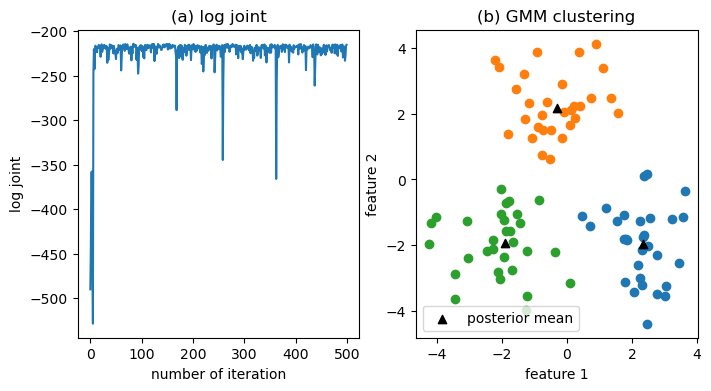

In [5]:
fig = plt.figure(figsize = (8, 4) )
plt.subplot(121)
plt.plot(a.logjoint_hist)
plt.xlabel('number of iteration')
plt.ylabel('log joint')
plt.title('(a) log joint')
z = a.z_cat.squeeze()
plt.subplot(122)
plt.title('(b) GMM clustering')
plt.scatter(data[z==0, 0],data[z==0, 1])
plt.scatter(data[z==1, 0],data[z==1, 1])
plt.scatter(data[z==2, 0],data[z==2, 1])
plt.scatter(a.beta[:,0],a.beta[:,1],color='black',zorder=2,marker='^', label='posterior mean')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend()
